# Scan2LOD Predictor
### Prediction Logic that Classifies Facade Data [Images and Conflictmaps (3D-Data)] of the same building with the help of Convolutional Neural Networks.

------------------------------------------------------------------------------
## Input: 572x572 image (.jpg) and 572x572 conflict map (.png)
------------------------------------------------------------------------------
## Output: Class for each individual pixel

The classes that are being output are:

-Facade

-Window

-Door

-Unknown

# 1. IMPORTING LIBRARIES


In [79]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.utils import save_image
import json
import pandas as pd
from tqdm.notebook import tqdm  # For progress bars
import time
import cv2

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. SETTING UP DIRECTORIES

In [81]:
# base directory
BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/Scan2LOD_DATA'

# Folders
INPUT_DIR = os.path.join(BASE_DIR, 'Inputs')
MODEL_DIR = os.path.join(BASE_DIR, 'Models')
OUTPUT_DIR = os.path.join(BASE_DIR, 'Outputs')

# Create folders if they don't exist
os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define paths for specific types of inputs
CONFLICT_MAP_DIR = os.path.join(INPUT_DIR, 'ConflictMaps')
IMAGE_DIR = os.path.join(INPUT_DIR, 'FacadeImages')
GROUND_TRUTH_DIR = os.path.join(INPUT_DIR, 'GroundTruth')  # If available

# Define paths for model files
UNET_MODEL_PATH = os.path.join(MODEL_DIR, 'unet_model.pth')
MASKRCNN_MODEL_PATH = os.path.join(MODEL_DIR, 'maskrcnn_model.pth')

# Create output subdirectories
UNET_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'UNet')
MASKRCNN_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'MaskRCNN')
FUSION_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'Fusion')

os.makedirs(UNET_OUTPUT_DIR, exist_ok=True)
os.makedirs(MASKRCNN_OUTPUT_DIR, exist_ok=True)
os.makedirs(FUSION_OUTPUT_DIR, exist_ok=True)

print("Directory structure initialized!")

Directory structure initialized!


In [82]:
# Adjust to change
# FacadeImage and conflict map paths

CONF_MAP_PATH = os.path.join(INPUT_DIR, 'ConflictMaps', 'Building23_ConflictMap_healed.png')
predictionPath = os.path.join(IMAGE_DIR, 'Building23_FacadeImage.png')


# 3. MODEL ARCHITECTURES (U-Net and MaskRCNN)


In [83]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding='same')  # Using 'same' padding
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding='same')
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding='same')
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding='same')
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding='same')
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding='same')
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding='same')

        # Decoder with size-matching upconvolution
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding='same')
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding='same')

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding='same')
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding='same')

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding='same')
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding='same')

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding='same')
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding='same')

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))

        # Decoder with size checking
        xu1 = self.upconv1(xe52)
        if xu1.size() != xe42.size():
            xu1 = F.interpolate(xu1, size=xe42.size()[2:])
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.relu(self.d11(xu11))
        xd12 = F.relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        if xu2.size() != xe32.size():
            xu2 = F.interpolate(xu2, size=xe32.size()[2:])
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        if xu3.size() != xe22.size():
            xu3 = F.interpolate(xu3, size=xe22.size()[2:])
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        if xu4.size() != xe12.size():
            xu4 = F.interpolate(xu4, size=xe12.size()[2:])
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = F.relu(self.d41(xu44))
        xd42 = F.relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)
        return out

In [84]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

# 4. LOADING MODELS

In [85]:
def load_unet_model(model_path, num_classes=4, device='cuda'):
    """Load a trained U-Net model"""
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model = UNet(n_class=num_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"U-Net model loaded from: {model_path}")
    return model


In [86]:
def load_maskrcnn_model(model_path, device='cuda'):
    """
    Load a trained Mask R-CNN model
    """
    # This is a placeholder - adjust based on your Mask R-CNN architecture
    try:

        # Initialize model with pre-trained weights
        num_classes = 2
        device = torch.device(device if torch.cuda.is_available() else "cpu")
        model = get_instance_segmentation_model(num_classes)
        weights = torch.load(model_path)

        # Load your trained weights
        model.load_state_dict(weights)
        model.to(device)
        model.eval()
        print(f"Mask R-CNN model loaded from: {model_path}")
        return model
    except Exception as e:
        print(f"Error loading Mask R-CNN model: {str(e)}")


In [87]:
def get_probabilities(self, x):
    """Get both raw logits and normalized probabilities"""
    logits = self.forward(x)
    probs = F.softmax(logits, dim=1)
    return logits, probs

In [88]:
def preprocess_conflict_map(conflict_map_path, device):
    """Preprocess a conflict map for the U-Net model"""
    # Color mappings for conflict map
    CONFLICT_MAP_COLORS = {
        'confirming': (0, 255, 0),  # Green - Confirming
        'unknown': (0, 0, 255),     # Blue - Unknown
        'conflict': (255, 0, 0)     # Red - Conflict
    }

    # Load conflict map as RGB
    conf_map = Image.open(conflict_map_path).convert('RGB')
    conf_map_array = np.array(conf_map)

    # Create input channels based on different conflict map states
    confirming_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['confirming'], axis=2)
    unknown_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['unknown'], axis=2)
    conflict_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['conflict'], axis=2)

    # Stack the masks into a 3-channel tensor
    conf_map_tensor = np.stack([confirming_mask, unknown_mask, conflict_mask], axis=0)
    conf_map_tensor = torch.from_numpy(conf_map_tensor).float().unsqueeze(0).to(device)

    return conf_map_tensor, conf_map_array

In [89]:
def preprocess_image(image_path, device, target_size=(572, 572)):
    # Load and normalize image for Mask R-CNN
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size, Image.LANCZOS)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)
    return image_tensor, np.array(image)

In [90]:
def preprocess_conflict_map(conflict_map_path, device):
    """Preprocess a conflict map for the U-Net model"""
    # Color mappings for conflict map
    CONFLICT_MAP_COLORS = {
        'confirming': (0, 255, 0),  # Green - Confirming
        'unknown': (0, 0, 255),     # Blue - Unknown
        'conflict': (255, 0, 0)     # Red - Conflict
    }

    # Load conflict map as RGB
    conf_map = Image.open(conflict_map_path).convert('RGB')
    conf_map_array = np.array(conf_map)

    # Create input channels based on different conflict map states
    confirming_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['confirming'], axis=2)
    unknown_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['unknown'], axis=2)
    conflict_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['conflict'], axis=2)

    # Stack the masks into a 3-channel tensor
    conf_map_tensor = np.stack([confirming_mask, unknown_mask, conflict_mask], axis=0)
    conf_map_tensor = torch.from_numpy(conf_map_tensor).float().unsqueeze(0).to(device)

    return conf_map_tensor, conf_map_array

In [91]:
def test_unet_output(model, conflict_map_path, device='cuda'):
    """Test UNet model on a conflict map and visualize outputs"""
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    # Preprocess conflict map
    conf_map_tensor, conf_map_array = preprocess_conflict_map(conflict_map_path, device)

    # Forward pass through UNet
    model.eval()
    with torch.no_grad():
        # Get raw logits from model
        logits = model(conf_map_tensor)

        # Convert logits to probabilities using softmax
        probs = F.softmax(logits, dim=1)

        # Get class predictions
        pred_classes = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

        # Convert to numpy for visualization
        logits_np = logits.squeeze().cpu().numpy()
        probs_np = probs.squeeze().cpu().numpy()

    # Define class names for visualization
    class_names = ['Facade', 'Window', 'Door', 'Unknown']

    # Visualize input
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_map_array)
    plt.title('Input Conflict Map')
    plt.axis('off')
    plt.show()

    # Visualize raw logits
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        plt.subplot(2, 2, i+1)
        plt.imshow(logits_np[i], cmap='viridis')
        plt.colorbar()
        plt.title(f'Raw Logits: {class_name}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Visualize probabilities
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        plt.subplot(2, 2, i+1)
        plt.imshow(probs_np[i], cmap='viridis', vmin=0, vmax=1)
        plt.colorbar()
        plt.title(f'Probability: {class_name}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Visualize predicted class
    class_colors = {
        0: [105, 105, 105],  # Facade - Gray
        1: [255, 255, 0],    # Window - Yellow
        2: [139, 69, 19],    # Door - Brown
        3: [220, 220, 220]   # Unknown - Light Gray
    }

    # Convert prediction to RGB
    rgb_pred = np.zeros((pred_classes.shape[0], pred_classes.shape[1], 3), dtype=np.uint8)
    for class_idx, color in class_colors.items():
        rgb_pred[pred_classes == class_idx] = color

    plt.figure(figsize=(10, 8))
    plt.imshow(rgb_pred)
    plt.title('UNet Prediction')
    plt.axis('off')
    plt.show()

    # Print statistics for each class
    print("Class probability statistics:")
    for i, class_name in enumerate(class_names):
        print(f"\n{class_name}:")
        print(f"  Min: {probs_np[i].min():.4f}")
        print(f"  Max: {probs_np[i].max():.4f}")
        print(f"  Mean: {probs_np[i].mean():.4f}")
        print(f"  Pixels predicted as {class_name}: {np.sum(pred_classes == i)} ({np.sum(pred_classes == i)/pred_classes.size*100:.2f}%)")

    # Return processed data for further analysis
    return {
        'raw_logits': logits_np,
        'probabilities': probs_np,
        'predictions': pred_classes
    }


## 5. Model Inference

In [92]:
def get_unet_predictions(model, conflict_map_tensor):
    with torch.no_grad():
        logits, probabilities = model.get_probabilities(conflict_map_tensor)
        predictions = torch.argmax(logits, dim=1).squeeze().cpu().numpy()
        probabilities = probabilities.squeeze().cpu().numpy()

    return predictions, probabilities

Using device: cuda
U-Net model loaded from: /content/drive/MyDrive/Colab Notebooks/Scan2LOD_DATA/Models/Facade_model_b14_e50_CMPGENREAL_nS.pth


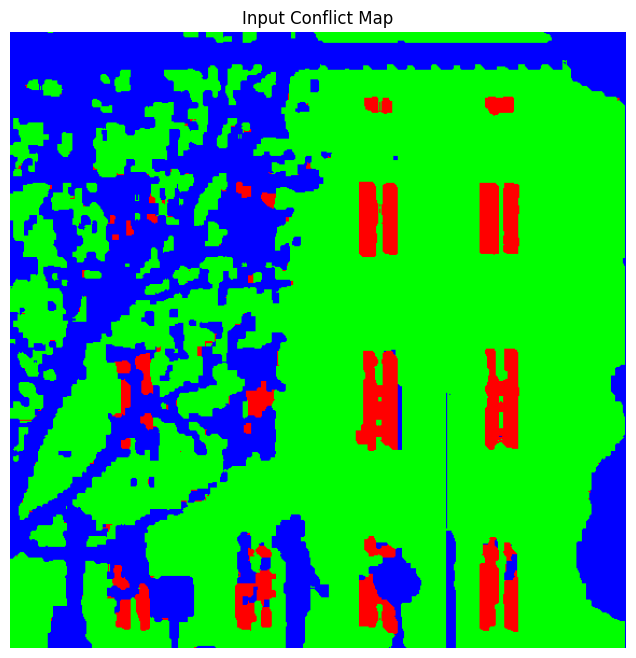

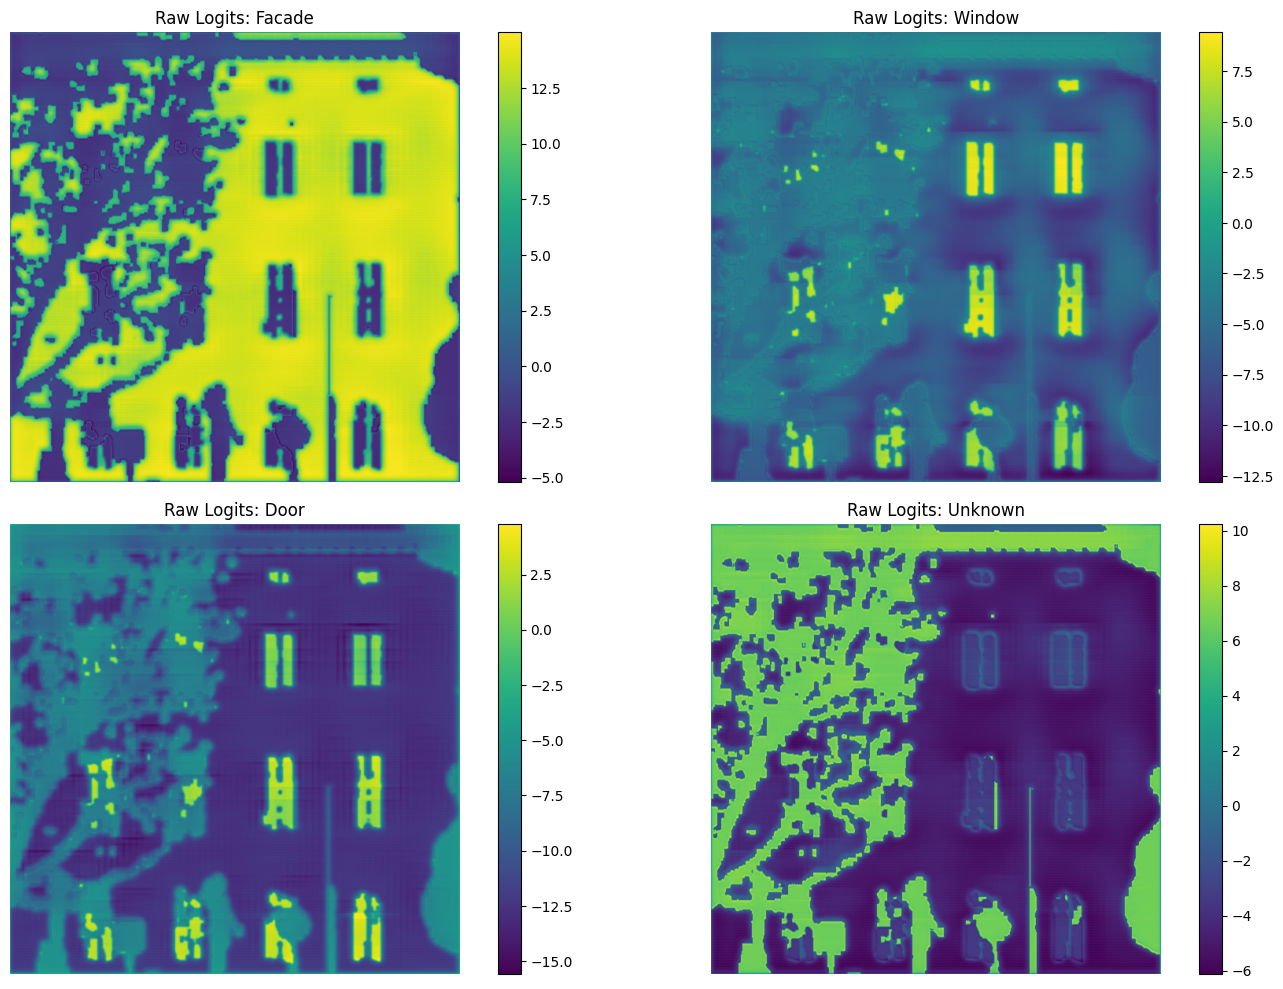

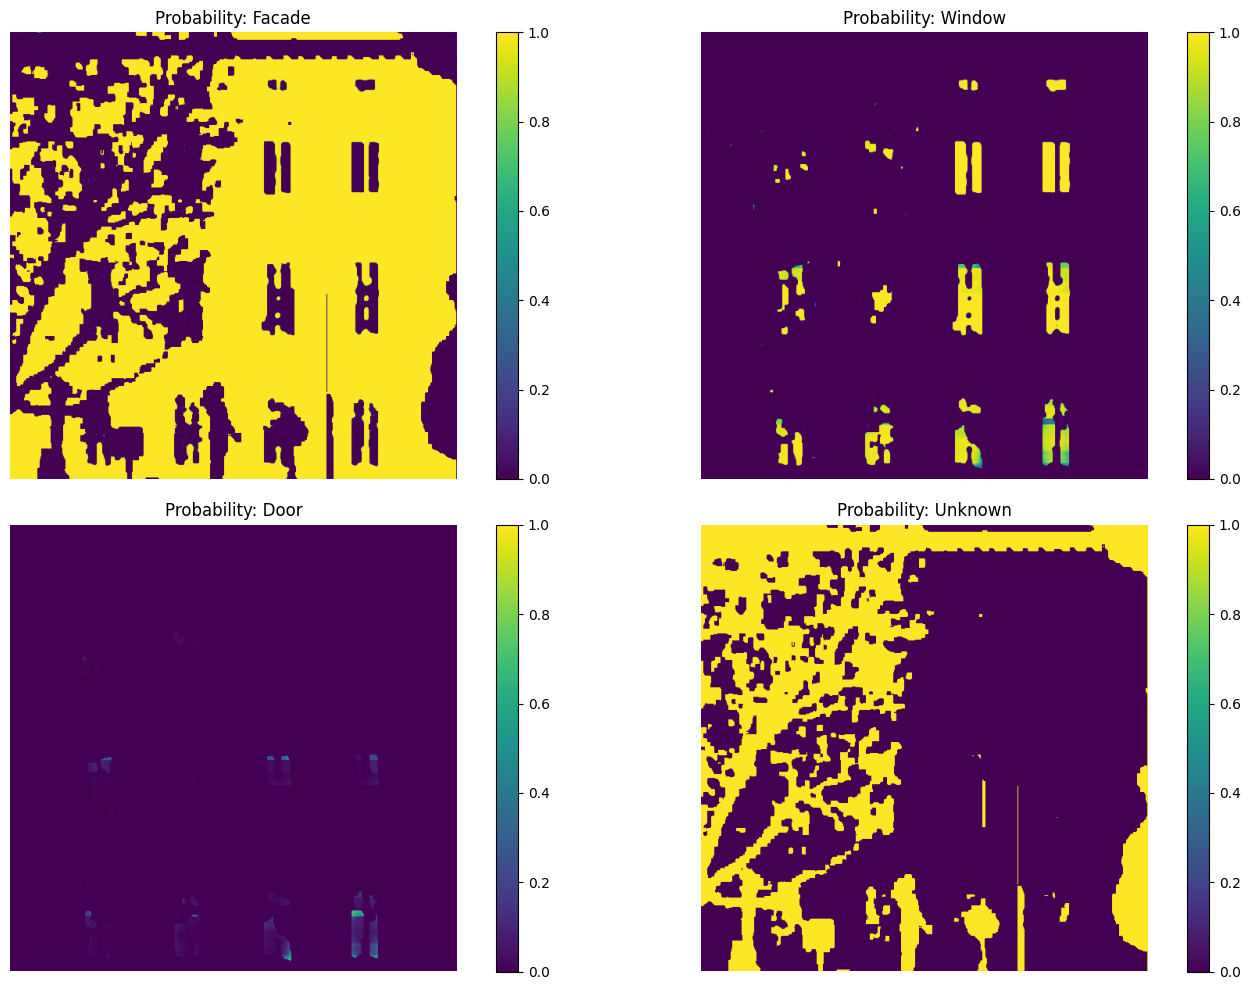

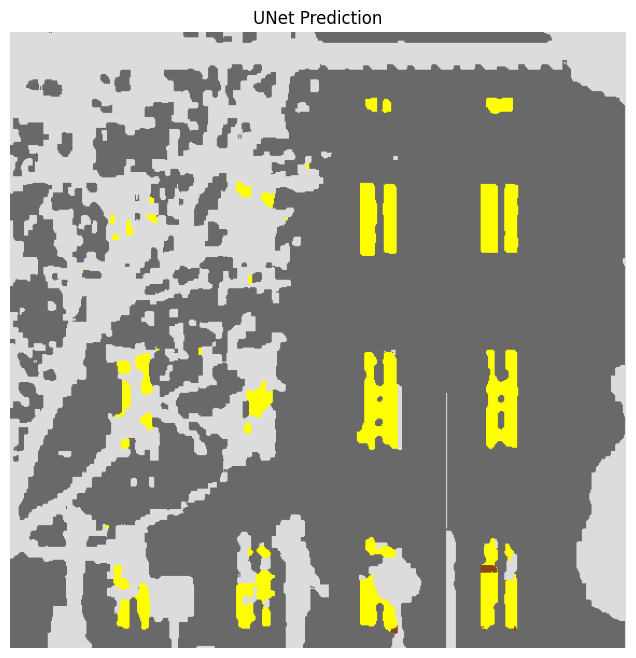

Class probability statistics:

Facade:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.6551
  Pixels predicted as Facade: 214288 (65.49%)

Window:
  Min: 0.0000
  Max: 0.9999
  Mean: 0.0467
  Pixels predicted as Window: 15658 (4.79%)

Door:
  Min: 0.0000
  Max: 0.8035
  Mean: 0.0018
  Pixels predicted as Door: 143 (0.04%)

Unknown:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.2964
  Pixels predicted as Unknown: 97095 (29.68%)


In [93]:
UNET_PATH = os.path.join(MODEL_DIR, 'Facade_model_b14_e50_CMPGENREAL_nS.pth')

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

unet_model = load_unet_model(UNET_PATH, num_classes=4, device=device)

# Test model output
unet_results = test_unet_output(unet_model, CONF_MAP_PATH, device=device)

In [94]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MaskRCNN_windows_model = load_maskrcnn_model(os.path.join(MODEL_DIR, 'MASK_RCNN_onlyWindows.pth'))
MaskRCNN_doors_model = load_maskrcnn_model(os.path.join(MODEL_DIR, 'MASK_RCNN_doors.pth'))

Mask R-CNN model loaded from: /content/drive/MyDrive/Colab Notebooks/Scan2LOD_DATA/Models/MASK_RCNN_onlyWindows.pth
Mask R-CNN model loaded from: /content/drive/MyDrive/Colab Notebooks/Scan2LOD_DATA/Models/MASK_RCNN_doors.pth


In [95]:
predImg = Image.open(predictionPath).convert("RGB")
transform = transforms.Compose([transforms.ToTensor()])
img_tensor = transform(predImg)

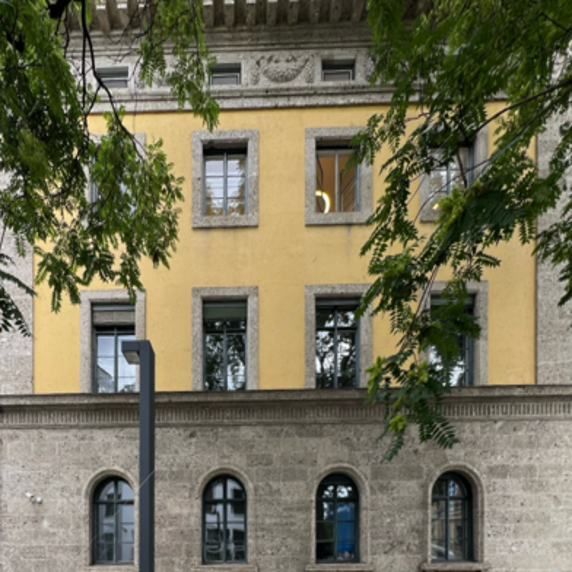

In [96]:
Image.fromarray(img_tensor.mul(255).permute(1, 2, 0).byte().numpy())

In [97]:
with torch.no_grad():
    prediction = MaskRCNN_windows_model([img_tensor.to(device)])
selected_photo = prediction[0]
selected_masks = selected_photo['masks']

#squeeze extra dimension given to the masks
selected_masks = torch.squeeze(selected_masks, 1)

#test = selected_masks[1] #first element of the tensor = first instance mask
num_of_masks = selected_masks.size(dim=0)
x_of_masks = selected_masks.size(dim=1)
y_of_masks = selected_masks.size(dim=2)

list_of_arrays = []
final_mask_windows = selected_masks.sum(axis=0)
for i in range(num_of_masks):
  np_arr = selected_masks[i].cpu().detach().numpy()
  list_of_arrays.append(np_arr)

one_composite_mask_windows = sum(list_of_arrays)

# save_path = path + "/results/wallBmaskFull.jpg"
# save_image(selected_masks, save_path)

In [98]:
with torch.no_grad():
    prediction = MaskRCNN_doors_model([img_tensor.to(device)])
selected_photo = prediction[0]
selected_masks = selected_photo['masks']

#squeeze extra dimension given to the masks
selected_masks = torch.squeeze(selected_masks, 1)

#test = selected_masks[1] #first element of the tensor = first instance mask
num_of_masks = selected_masks.size(dim=0)
x_of_masks = selected_masks.size(dim=1)
y_of_masks = selected_masks.size(dim=2)

list_of_arrays = []
final_mask_doors = selected_masks.sum(axis=0)
for i in range(num_of_masks):
  np_arr = selected_masks[i].cpu().detach().numpy()
  list_of_arrays.append(np_arr)

one_composite_mask_doors = sum(list_of_arrays)

# save_path = path + "/results/wallBmaskFull.jpg"
# save_image(selected_masks, save_path)



In [99]:
prediction

[{'boxes': tensor([[199.3227, 296.1051, 249.0752, 390.0984],
          [309.7109, 297.2607, 362.2439, 388.1048],
          [428.8161, 466.5043, 480.6647, 564.0886],
          [ 87.1448, 468.2942, 135.3781, 568.2108],
          [314.5836, 465.8663, 362.6943, 563.3519],
          [199.4565, 467.8170, 248.9714, 564.0819]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.8690, 0.6792, 0.2053, 0.1250, 0.0711, 0.0606], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0., 

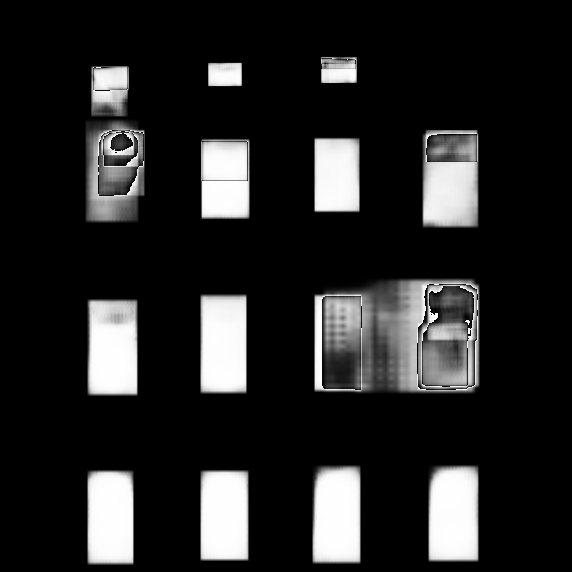

In [100]:
Image.fromarray(final_mask_windows.mul(255).byte().cpu().numpy())

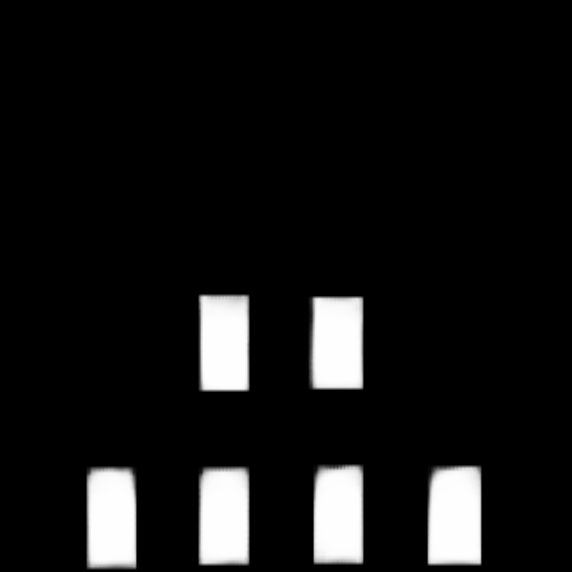

In [101]:
Image.fromarray(final_mask_doors.mul(255).byte().cpu().numpy())

In [102]:
def normalize_maskrcnn_output(mask, epsilon=1e-8):
    """
    Normalize Mask R-CNN output to scale pixel values between 0 and 1.
    Simply finds global min and max and scales all values.

    Parameters:
    mask: Instance masks from Mask R-CNN
    epsilon: Small value to prevent division by zero

    Returns:
    Normalized probability tensor
    """
    # Move tensor to CPU and convert to numpy
    logits = mask.cpu().numpy()

    # Get the global min and max across the entire array, regardless of shape
    min_val = np.min(logits)
    max_val = np.max(logits)

    # Simple min-max normalization
    range_val = max_val - min_val
    if range_val < epsilon:
        # If there's no variation, return zeros in the original shape
        return np.zeros_like(logits)

    # Normalize to [0,1] range
    normalized = (logits - min_val) / range_val

    # If we need a single 2D image as output, take the max across instance dimension if it exists
    if len(normalized.shape) == 3:
        normalized = np.max(normalized, axis=0)

    return normalized

In [103]:
## Unet output
unet_probs = unet_results['probabilities']  # Shape [4, height, width]
#unet_pred = unet_results['predictions']    # Shape [height, width]

## MaskRCNN outputs
window_probs = normalize_maskrcnn_output(final_mask_windows)
window_probs.reshape((572, 572))

#windows_blinds_probs = normalize_maskrcnn_output(final_mask_windows_blinds)
#windows_blinds_probs.reshape((572, 572))

#door_probs = window_probs + windows_blinds_probs



# Apply the condition using NumPy's boolean indexing
#door_probs[door_probs < 1] = 0  # Set values above X to zero

door_probs = normalize_maskrcnn_output(final_mask_doors)

# Renormalize after addition
if np.max(door_probs) > 0:
    door_probs = door_probs / np.max(door_probs)

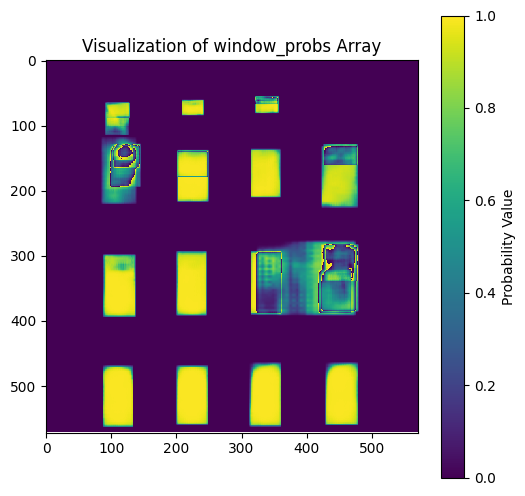

In [104]:
# Plot the heatmap
plt.figure(figsize=(6, 6))
#plt.imshow(unet_probs[1], cmap="viridis", interpolation="nearest")
#plt.imshow(window_probs, cmap="viridis", interpolation="nearest")



plt.imshow(final_mask_windows.mul(255).byte().cpu().numpy()/255, cmap="viridis", interpolation="nearest")

plt.colorbar(label="Probability Value")
plt.title("Visualization of window_probs Array")
plt.show()

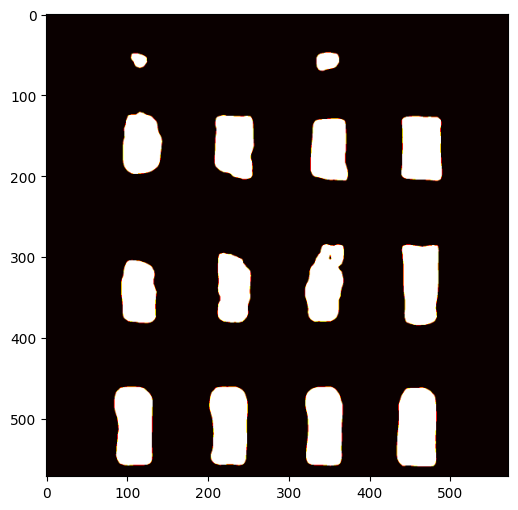

In [122]:
import matplotlib.image as img
import matplotlib.pyplot as plt

BINARY_DIR = os.path.join(INPUT_DIR, 'binaryMasks')
binaryMaskPath = os.path.join(BINARY_DIR, '02_segformer_prediction2.png')


mask2former_prediction = img.imread(binaryMaskPath)
plt.figure(figsize=(6, 6))
plt.imshow(mask2former_prediction, cmap="viridis")
plt.imshow(mask2former_prediction[:,:,0], cmap="hot")
#plt.imshow(mask2former_prediction, cmap="hot")
#plt.colorbar(label="Probability Value")
#plt.title("Visualization of window probs")
plt.show()

## 6. Semantic Fusion

The fusion of the predictions happens with a set of hyperparameters that form our final estimate by weighting the estimates of Windows and Doors segmented by our Unet with the estimates from the MaskRCNN. Facade and Unknown classes will be directly taken from the UNet.

In [123]:
def combine_predictions_linear(unet_probs, window_probs, door_probs):
    """
    Create a linear weighted combination of UNet and Mask R-CNN predictions

    Parameters:
        unet_probs: UNet probabilities [4, height, width] - all classes
        window_probs: Window probabilities from Mask R-CNN [height, width]
        door_probs: Door probabilities from Mask R-CNN [height, width], optional
        window_weight: Weight for Mask R-CNN window prediction (1-window_weight for UNet)
        door_weight: Weight for Mask R-CNN door prediction (1-door_weight for UNet)

    Returns:
        combined_probs: Combined probability tensor [4, height, width]
    """
    # Create a copy of UNet probabilities to avoid modifying original
    combined_probs = unet_probs.copy()

    # For window class [1], apply weighted combination
    if window_probs is not None:
        window_alpha = 3
        window_beta = 6 #3 was valid for 57 // 6 was valid for 57_2
        combined_probs[1] = window_alpha * unet_probs[1] + window_beta * window_probs

    # For door class [2], apply weighted combination if available
    if door_probs is not None:
        door_alpha = 4.5
        door_beta = 1
        combined_probs[2] = door_alpha * unet_probs[2] + door_beta * door_probs

    # Unknowns
    combined_probs[3] = 6* combined_probs[3]

    # Normalize probabilities to sum to 1 for each pixel
    sum_probs = np.sum(combined_probs, axis=0)
    for i in range(combined_probs.shape[0]):
        combined_probs[i] /= sum_probs

    return combined_probs

def adaptive_combine_predictions(unet_probs, window_probs, door_probs=None,
                               window_threshold=0.3, door_threshold=0.3):
    """
    Create an adaptive weighted combination based on UNet confidence

    Parameters:
        unet_probs: UNet probabilities [4, height, width] - all classes
        window_probs: Window probabilities from Mask R-CNN [height, width]
        door_probs: Door probabilities from Mask R-CNN [height, width], optional
        window_threshold: Confidence threshold for windows
        door_threshold: Confidence threshold for doors

    Returns:
        combined_probs: Combined probability tensor [4, height, width]
    """
    # Create a copy of UNet probabilities to avoid modifying original
    combined_probs = unet_probs.copy()


    # Calculate UNet confidence for each class
    window_confidence = unet_probs[1]
    door_confidence = unet_probs[2]

    # WINDOWS: use Mask R-CNN more where UNet is less confident
    if window_probs is not None:
        # Calculate adaptive weights based on confidence
        window_weight = np.where(window_confidence < window_threshold, 0.8, 0.2)

        # Apply weighted combination
        combined_probs[1] = (1 - window_weight) * unet_probs[1] + window_weight * window_probs

    # DOORS: use Mask R-CNN more where UNet is less confident
    if door_probs is not None:
        # Calculate adaptive weights based on confidence
        door_weight = np.where(door_confidence < door_threshold, 0.8, 0.2)

        # Apply weighted combination
        combined_probs[2] = (1 - door_weight) * unet_probs[2] + door_weight * door_probs

    # Normalize probabilities to sum to 1 for each pixel
    sum_probs = np.sum(combined_probs, axis=0)
    for i in range(combined_probs.shape[0]):
        combined_probs[i] /= sum_probs

    return combined_probs



In [124]:
combined_probs = combine_predictions_linear(
     unet_probs,                # From UNet
     mask2former_prediction[:,:,2],    # From Mask2Former
     np.zeros((572,572))
 )

combined_probs = combine_predictions_linear(
     unet_probs,                # From UNet
     mask2former_prediction[:,:,2],    # From Mask2Former
     np.zeros((572,572))
 )

#combined_probs = adaptive_combine_predictions(
 #    unet_probs,            # From UNet
 #    window_probs,          # From Window Mask R-CNN
 #    door_probs,            # From Door Mask R-CNN (optional)
 #    window_threshold=0.4,
 #    door_threshold=0.4
 #)

 # Get final prediction
final_pred = np.argmax(combined_probs, axis=0)

## 7. Final Prediction

In [125]:
def visualize_final_prediction(pred, original_image=None, save_path=None, show_plot=True):
    """
    Visualize the final prediction with optional comparison to inputs and individual model outputs

    Parameters:
        pred: Final prediction array of shape [height, width] with class indices
        original_image: Original input image (optional)
        unet_pred: UNet prediction array (optional)
        maskrcnn_pred: Mask R-CNN prediction array (optional)
        save_path: Path to save the visualization (optional)
        show_plot: Whether to display the plot (default True)
    """
    # Define class colors
    class_colors = {
        0: [105, 105, 105],  # Facade - Gray
        1: [255, 255, 0],    # Window - Yellow
        2: [139, 69, 19],    # Door - Brown
        3: [220, 220, 220]   # Unknown - Light Gray
    }

    # Function to convert prediction to RGB
    def pred_to_rgb(pred_array):
        height, width = pred_array.shape
        rgb = np.zeros((height, width, 3), dtype=np.uint8)
        for class_idx, color in class_colors.items():
            mask = (pred_array == class_idx)
            rgb[mask] = color
        return rgb

    # Convert final prediction to RGB
    rgb_pred = pred_to_rgb(pred)

    # Determine the number of subplots needed
    num_plots = 1
    if original_image is not None:
        num_plots += 1

    # Create figure with appropriate size
    fig = plt.figure(figsize=(5*num_plots, 5))

    # Plot counter
    plot_idx = 1

    # Original image
    if original_image is not None:
        plt.subplot(1, num_plots, plot_idx)
        plt.imshow(original_image)
        plt.title("Original Image")
        plt.axis('off')
        plot_idx += 1

    # Final prediction
    plt.subplot(1, num_plots, plot_idx)
    plt.imshow(rgb_pred)
    plt.title("Final Prediction")
    plt.axis('off')

    # Add a legend
    legend_elements = []
    class_names = ["Facade", "Window", "Door", "Unknown"]
    for i, (class_idx, color) in enumerate(class_colors.items()):
        # Convert RGB to matplotlib format (0-1)
        mpl_color = [c/255 for c in color]
        legend_elements.append(plt.Rectangle((0,0), 1, 1, color=mpl_color, label=class_names[i]))

    # Add the legend to the right side of the plot
    fig.legend(handles=legend_elements, loc='center right', title="Classes")

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout for legend

    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {save_path}")

    # Show if requested
    if show_plot:
        plt.show()
    else:
        plt.close()

    return rgb_pred

Visualization saved to /content/drive/MyDrive/Colab Notebooks/Scan2LOD_DATA/Outputs/fusion_result.png


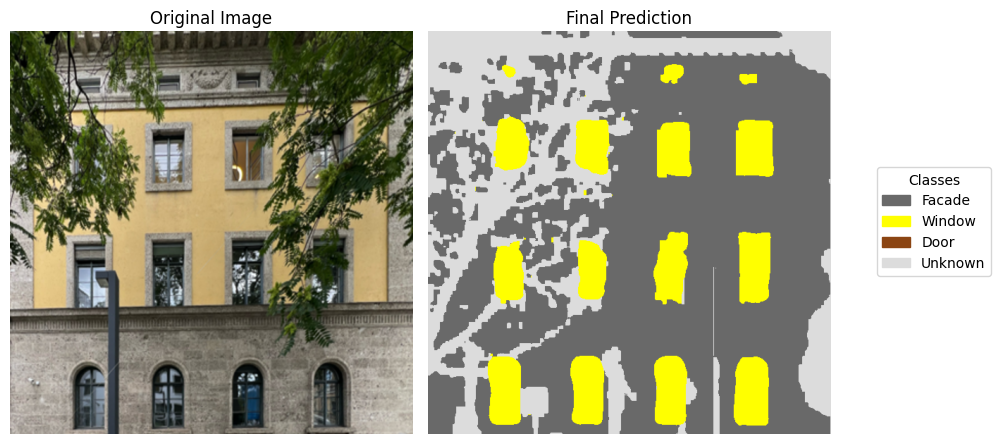

array([[[220, 220, 220],
        [220, 220, 220],
        [220, 220, 220],
        ...,
        [220, 220, 220],
        [220, 220, 220],
        [220, 220, 220]],

       [[220, 220, 220],
        [220, 220, 220],
        [220, 220, 220],
        ...,
        [220, 220, 220],
        [220, 220, 220],
        [220, 220, 220]],

       [[220, 220, 220],
        [220, 220, 220],
        [220, 220, 220],
        ...,
        [220, 220, 220],
        [220, 220, 220],
        [220, 220, 220]],

       ...,

       [[105, 105, 105],
        [105, 105, 105],
        [105, 105, 105],
        ...,
        [105, 105, 105],
        [105, 105, 105],
        [220, 220, 220]],

       [[105, 105, 105],
        [105, 105, 105],
        [105, 105, 105],
        ...,
        [105, 105, 105],
        [105, 105, 105],
        [220, 220, 220]],

       [[105, 105, 105],
        [105, 105, 105],
        [105, 105, 105],
        ...,
        [105, 105, 105],
        [105, 105, 105],
        [220, 220, 220]]], dtype=uint8)
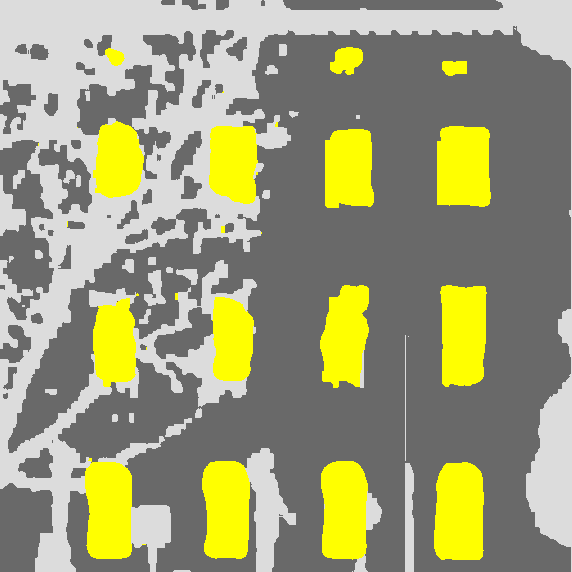

In [126]:
# Get the final prediction
final_pred = np.argmax(combined_probs, axis=0)

# Visualize with comparisons
original_image = np.array(Image.open(predictionPath).convert("RGB"))
visualize_final_prediction(
    final_pred,
    original_image=original_image,
    save_path=os.path.join(OUTPUT_DIR, "fusion_result.png"))

#3D Reconstruction

# 8. Reconstruction with WallMatching

- export unter LOD3 output
- brauchen die Facade ID von der Frontfacade

In [127]:
import os
import numpy as np
import cv2
from lxml import etree
import uuid
from datetime import datetime
from pathlib import Path

In [128]:
def visualize_contours_before_gml(prediction, window_contours, door_contours, save_path=None):
    """Visualize the contours found from the prediction masks before GML conversion"""

    # Create a color image from the original prediction
    pred_color = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)

    # Color the prediction
    class_colors = {
        0: [105, 105, 105],  # Facade - Gray
        1: [255, 255, 0],    # Window - Yellow
        2: [139, 69, 19],    # Door - Brown
        3: [220, 220, 220]   # Unknown - Light Gray
    }

    for class_idx, color in class_colors.items():
        pred_color[prediction == class_idx] = color

    # Draw window contours in green
    cv2.drawContours(pred_color, window_contours, -1, (0, 255, 0), 2)

    # Draw door contours in red
    cv2.drawContours(pred_color, door_contours, -1, (255, 0, 0), 2)

    # Create a visualization showing:
    # 1. Original prediction
    # 2. Binary masks
    # 3. Detected contours

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Original prediction
    axes[0, 0].imshow(pred_color)
    axes[0, 0].set_title('Original Prediction')
    axes[0, 0].axis('off')

    # Window mask
    window_mask = (prediction == 1).astype(np.uint8) * 255
    axes[0, 1].imshow(window_mask, cmap='gray')
    axes[0, 1].set_title('Window Mask')
    axes[0, 1].axis('off')

    # Door mask
    door_mask = (prediction == 2).astype(np.uint8) * 255
    axes[0, 2].imshow(door_mask, cmap='gray')
    axes[0, 2].set_title('Door Mask')
    axes[0, 2].axis('off')

    # Window contours overlaid
    window_overlay = pred_color.copy()
    cv2.drawContours(window_overlay, window_contours, -1, (0, 255, 0), 3)
    axes[1, 0].imshow(window_overlay)
    axes[1, 0].set_title(f'Window Contours ({len(window_contours)})')
    axes[1, 0].axis('off')

    # Door contours overlaid
    door_overlay = pred_color.copy()
    cv2.drawContours(door_overlay, door_contours, -1, (255, 0, 0), 3)
    axes[1, 1].imshow(door_overlay)
    axes[1, 1].set_title(f'Door Contours ({len(door_contours)})')
    axes[1, 1].axis('off')

    # All contours combined
    all_contours = pred_color.copy()
    cv2.drawContours(all_contours, window_contours, -1, (0, 255, 0), 3)
    cv2.drawContours(all_contours, door_contours, -1, (255, 0, 0), 3)

    # Add contour numbers for reference
    for idx, contour in enumerate(window_contours):
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.putText(all_contours, f"W{idx}", (cX, cY),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    for idx, contour in enumerate(door_contours):
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.putText(all_contours, f"D{idx}", (cX, cY),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    axes[1, 2].imshow(all_contours)
    axes[1, 2].set_title('All Contours with Labels')
    axes[1, 2].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        # Also save the final contour overlay separately
        cv2.imwrite(save_path.replace('.png', '_contours.png'),
                    cv2.cvtColor(all_contours, cv2.COLOR_RGB2BGR))

    plt.show()

    return all_contours

In [129]:
# Define CityGML namespaces
ns_citygml = "http://www.opengis.net/citygml/2.0"
ns_gml = "http://www.opengis.net/gml"
ns_bldg = "http://www.opengis.net/citygml/building/2.0"
ns_app = "http://www.opengis.net/citygml/appearance/2.0"

def extract_wall_surfaces(gml_tree):
    """Extract all wall surfaces from a CityGML file"""
    wall_surfaces = []
    for wall in gml_tree.findall(f".//{{{ns_bldg}}}WallSurface"):
        wall_id = wall.get(f"{{{ns_gml}}}id")
        # Find wall polygons to get coordinates
        polygons = []
        for polygon in wall.findall(f".//{{{ns_gml}}}Polygon"):
            pos_list = polygon.find(f".//{{{ns_gml}}}posList")
            if pos_list is not None and pos_list.text:
                coords_text = pos_list.text.strip()
                coords = [float(x) for x in coords_text.split()]
                polygons.append({
                    "id": polygon.get(f"{{{ns_gml}}}id"),
                    "coords": coords
                })

        wall_surfaces.append({
            "id": wall_id,
            "element": wall,
            "polygons": polygons
        })

    return wall_surfaces

def calculate_wall_dimensions(coords):
    """Calculate approximate width and height of a wall from coordinates"""
    # Convert flat coordinate list to points
    points = []
    for i in range(0, len(coords), 3):
        if i+2 < len(coords):
            points.append((coords[i], coords[i+1], coords[i+2]))

    if len(points) < 4:
        return 1, 1  # Default fallback

    # Find min and max z values (height)
    z_values = [p[2] for p in points]
    height = max(z_values) - min(z_values)

    # For width, use horizontal distance between points
    # (simplified - just using the first and second points as estimate)
    width = np.sqrt((points[1][0] - points[0][0])**2 + (points[1][1] - points[0][1])**2)

    return width, height

def find_wall_orientation(coords):
    """Find the orientation of a wall to position openings correctly"""
    points = []
    for i in range(0, len(coords), 3):
        if i+2 < len(coords):
            points.append((coords[i], coords[i+1], coords[i+2]))

    if len(points) < 4:
        return (1, 0, 0)  # Default fallback

    # Calculate normal vector (simplified)
    # Using the first three points to determine orientation
    p0 = np.array(points[0])
    p1 = np.array(points[1])
    p2 = np.array(points[2])

    v1 = p1 - p0
    v2 = p2 - p1

    # Cross product gives normal vector
    normal = np.cross(v1, v2)

    # Normalize
    length = np.linalg.norm(normal)
    if length > 0:
        normal = normal / length

    return normal

def extract_wall_corners(wall_coords):
    """Extract the four corners of the wall: bottom-left, bottom-right, top-right, top-left"""
    # Convert flat coordinates to points
    points = []
    for i in range(0, len(wall_coords), 3):
        if i+2 < len(wall_coords):
            points.append((wall_coords[i], wall_coords[i+1], wall_coords[i+2]))

    # Convert to numpy array for processing
    points_array = np.array(points)

    # Find min and max Z values (to separate bottom and top)
    z_values = points_array[:, 2]
    min_z = np.min(z_values)
    max_z = np.max(z_values)

    # Separate bottom and top points by Z-coordinate
    bottom_points = points_array[np.isclose(points_array[:, 2], min_z)]
    top_points = points_array[np.isclose(points_array[:, 2], max_z)]

    # Sort the points to identify corners
    bottom_sorted = bottom_points[np.argsort(bottom_points[:, 0])]
    top_sorted = top_points[np.argsort(top_points[:, 0])]

    # Extract corners
    bottom_left = bottom_sorted[0]
    bottom_right = bottom_sorted[-1]
    top_right = top_sorted[-1]
    top_left = top_sorted[0]

    return {
        "bottom_left": bottom_left,
        "bottom_right": bottom_right,
        "top_right": top_right,
        "top_left": top_left
    }

def create_prediction_to_wall_mapping(wall_corners, pred_shape):
    """Create a transformation function that maps prediction coordinates to 3D wall coordinates"""
    # Extract prediction dimensions
    pred_height, pred_width = pred_shape

    def map_pred_to_wall(x, y):
        """Map a point in prediction space to wall 3D space using bilinear interpolation"""
        # Normalize coordinates to [0, 1] range
        u = x / pred_width
        v = 1.0 - (y / pred_height)  # Invert v because image y is top-to-bottom

        # Bilinear interpolation in 3D
        # First interpolate the bottom edge
        bottom = (1 - u) * wall_corners["bottom_left"] + u * wall_corners["bottom_right"]

        # Then interpolate the top edge
        top = (1 - u) * wall_corners["top_left"] + u * wall_corners["top_right"]

        # Finally interpolate between bottom and top
        point_3d = (1 - v) * bottom + v * top

        return point_3d

    return map_pred_to_wall

def extract_opening_dimensions(contour, pred_shape, wall_corners):
    """Map an opening contour from the prediction to 3D coordinates on the wall

    --------------
    This was chosen in order to generate a safe output. Since interior
       rings can approximate any polygon, we also experiment with other approximations



    """
    # Get the bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)

    # Create mapping function
    mapping_func = create_prediction_to_wall_mapping(wall_corners, pred_shape)

    # Map the corners of the bounding rectangle to 3D
    bottom_left_3d = mapping_func(x, y + h)
    bottom_right_3d = mapping_func(x + w, y + h)
    top_right_3d = mapping_func(x + w, y)
    top_left_3d = mapping_func(x, y)

    # Create flat coordinate list in the correct order
    opening_coords = []
    opening_coords.extend(bottom_left_3d)
    opening_coords.extend(bottom_right_3d)
    opening_coords.extend(top_right_3d)
    opening_coords.extend(top_left_3d)
    opening_coords.extend(bottom_left_3d)  # Close the loop

    return {
        "coordinates": opening_coords,
        "width": np.linalg.norm(bottom_right_3d - bottom_left_3d),
        "height": np.linalg.norm(top_left_3d - bottom_left_3d)
    }

#def extract_opening_dimensions(contour, pred_shape, wall_corners):
#    """Map an opening contour from the prediction to 3D coordinates on the wall
#
#   ---
#    This version approximates the shapes of the prediction better
#
#
#   """
#
#   # Create mapping function
#    mapping_func = create_prediction_to_wall_mapping(wall_corners, pred_shape)
#
#   # Simplify contour if needed to reduce complexity
#    # epsilon parameter can be adjusted - smaller values preserve more detail
#    epsilon = 0.01 * cv2.arcLength(contour, True)  # 1% of the contour's perimeter
#    approx_contour = cv2.approxPolyDP(contour, epsilon, True)
#
#    # Extract 2D points from the simplified contour
#    contour_points = approx_contour.squeeze()
#
#    # If we have less than 3 points after simplification, use original contour
#    if len(contour_points) < 3:
#        contour_points = contour.squeeze()
#
#    # If still less than 3 points, fallback to rectangle
#    if len(contour_points) < 3:
#        x, y, w, h = cv2.boundingRect(contour)
#        contour_points = np.array([
#            [x, y],
#            [x + w, y],
#            [x + w, y + h],
#            [x, y + h]
#        ])

    # Map each contour point to 3D coordinates
#    opening_coords = []
#    for point in contour_points:
#        x, y = point
#        point_3d = mapping_func(x, y)
#        opening_coords.extend(point_3d)
#
#    # Close the loop by adding the first point again if needed
#    if not np.array_equal(contour_points[0], contour_points[-1]):
#        opening_coords.extend(mapping_func(contour_points[0][0], contour_points[0][1]))
#
#    # Calculate approximate width and height for reference (bounding box)
#    x_coords = [coord for i, coord in enumerate(opening_coords) if i % 3 == 0]
#    y_coords = [coord for i, coord in enumerate(opening_coords) if i % 3 == 1]
#    z_coords = [coord for i, coord in enumerate(opening_coords) if i % 3 == 2]
#
#    # Approximate dimensions (still useful for metadata)
#    width = max(x_coords) - min(x_coords)
#   height = max(z_coords) - min(z_coords)
#
#    return {
#        "coordinates": opening_coords,
#        "width": width,
#        "height": height,
#        "num_vertices": len(contour_points)  # Additional info for debugging
#    }


def generate_opening_coords(wall_coords, relative_position, size, opening_type):
    """
    Generate 3D coordinates for an opening on a wall

    Parameters:
    - wall_coords: List of wall coordinates
    - relative_position: (x, y) position in [0,1] range relative to wall dimensions
    - size: (width, height) in real-world units
    - opening_type: "window" or "door"

    Returns:
    - List of 3D coordinates for the opening
    """
    # Convert flat coordinate list to points
    points = []
    for i in range(0, len(wall_coords), 3):
        if i+2 < len(wall_coords):
            points.append((wall_coords[i], wall_coords[i+1], wall_coords[i+2]))

    if len(points) < 4:
        return []  # Not enough points

    # Find min/max values for each dimension
    x_values = [p[0] for p in points]
    y_values = [p[1] for p in points]
    z_values = [p[2] for p in points]

    x_min, x_max = min(x_values), max(x_values)
    y_min, y_max = min(y_values), max(y_values)
    z_min, z_max = min(z_values), max(z_values)

    # Calculate wall dimensions
    width = max(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2), 0.1)
    height = max(z_max - z_min, 0.1)

    # Find orientation
    orientation = find_wall_orientation(wall_coords)

    # Calculate the wall's primary direction vector
    # (vector between first two points)
    if len(points) >= 2:
        direction = np.array([points[1][0] - points[0][0],
                            points[1][1] - points[0][1],
                            0])  # Keep it horizontal
        direction_length = np.linalg.norm(direction)
        if direction_length > 0:
            direction = direction / direction_length
    else:
        direction = np.array([1, 0, 0])  # Default

    # Default heights based on opening type
    if opening_type == "door":
        # Doors start at the bottom of the wall
        bottom_z = z_min
        top_z = z_min + min(size[1], height * 0.8)  # Limit door height
    else:  # window
        # Windows are positioned between 1/3 and 2/3 of wall height
        window_height = min(size[1], height * 0.4)  # Limit window height
        bottom_z = z_min + height * 0.4 - window_height / 2
        top_z = bottom_z + window_height

    # X and Y position - use the wall's origin plus offset along direction
    rel_x, rel_y = relative_position

    # Adjust to keep within wall bounds
    rel_x = max(0.05, min(0.95, rel_x))

    # Calculate the horizontal offset along the wall
    offset = width * rel_x

    # Calculate the starting point
    start_x = points[0][0] + direction[0] * offset
    start_y = points[0][1] + direction[1] * offset

    # Calculate perpendicular vector (pointing outward from wall)
    perp = np.cross(direction, np.array([0, 0, 1]))
    perp_length = np.linalg.norm(perp)
    if perp_length > 0:
        perp = perp / perp_length
    else:
        perp = np.array([0, 1, 0])  # Default fallback

    # Calculate the four corners of the opening
    half_width = size[0] / 2

    # Bottom left, Bottom right, Top right, Top left, Bottom left (to close the ring)
    corners = [
        (start_x - direction[0] * half_width, start_y - direction[1] * half_width, bottom_z),
        (start_x + direction[0] * half_width, start_y + direction[1] * half_width, bottom_z),
        (start_x + direction[0] * half_width, start_y + direction[1] * half_width, top_z),
        (start_x - direction[0] * half_width, start_y - direction[1] * half_width, top_z),
        (start_x - direction[0] * half_width, start_y - direction[1] * half_width, bottom_z)
    ]

    # Flatten the coordinates
    flat_coords = []
    for corner in corners:
        flat_coords.extend(corner)

    return flat_coords

def process_facade_openings(prediction, wall_coords, save_visualization=True, vis_path=None):
    """
    Process facade prediction to extract properly positioned openings
    """
    # Extract wall corners to understand the 3D space
    wall_corners = extract_wall_corners(wall_coords)

    # Create binary masks for windows and doors
    window_mask = (prediction == 1).astype(np.uint8) * 255
    door_mask = (prediction == 2).astype(np.uint8) * 255

    # Find contours in the masks
    window_contours, _ = cv2.findContours(window_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    door_contours, _ = cv2.findContours(door_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize results
    windows = []
    doors = []

    # Process window contours with size filtering
    min_area = 200  # Minimum contour area to filter out noise
    max_area = 10000  # Maximum contour area to filter out large objects

    filtered_window_contours = []
    for contour in window_contours:
        area = cv2.contourArea(contour)
        if min_area <= area <= max_area:
            filtered_window_contours.append(contour)
            opening_info = extract_opening_dimensions(contour, prediction.shape, wall_corners)
            windows.append(opening_info)

    # Process door contours with size filtering
    filtered_door_contours = []
    for contour in door_contours:
        area = cv2.contourArea(contour)
        if min_area <= area <= max_area:
            filtered_door_contours.append(contour)
            opening_info = extract_opening_dimensions(contour, prediction.shape, wall_corners)
            doors.append(opening_info)

    # Create visualizations after filtering
    if save_visualization:
        # 1. Full visualization with background
        vis_img = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)

        # Draw the original prediction as background
        vis_img[prediction == 0] = [105, 105, 105]  # Facade - Gray
        vis_img[prediction == 1] = [255, 255, 0]    # Window - Yellow
        vis_img[prediction == 2] = [139, 69, 19]    # Door - Brown
        vis_img[prediction == 3] = [220, 220, 220]  # Unknown - Light Gray

        # Draw filtered contours with thick green lines
        cv2.drawContours(vis_img, filtered_window_contours, -1, (0, 255, 0), 2)  # Green for windows
        cv2.drawContours(vis_img, filtered_door_contours, -1, (0, 255, 255), 2)   # Cyan for doors

        # Save the full visualization
        if vis_path is None:
            vis_path = "contours_filtered_visualization.png"

        cv2.imwrite(vis_path, cv2.cvtColor(vis_img, cv2.COLOR_RGB2BGR))

        # 2. Create contours-only visualization (black background)
        contours_only_img = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)

        # Draw ONLY the filtered contours (these are what will go into the GML)
        cv2.drawContours(contours_only_img, filtered_window_contours, -1, (255, 255, 0), -1)  # Fill windows in yellow
        cv2.drawContours(contours_only_img, filtered_door_contours, -1, (139, 69, 19), -1)    # Fill doors in brown

        # Save the contours-only visualization
        contours_only_path = vis_path.replace('.png', '_contours_only.png')
        cv2.imwrite(contours_only_path, cv2.cvtColor(contours_only_img, cv2.COLOR_RGB2BGR))


        # 3. Create matplotlib visualization with all views
        fig, axes = plt.subplots(2, 1, figsize=(16, 16))

        # Original prediction
        axes[0].imshow(vis_img)
        axes[0].set_title('Original Prediction with Filtered Contours')
        axes[0].axis('off')

        # Contours only
        axes[1].imshow(contours_only_img)
        axes[1].set_title('Filtered Contours Only (For GML)')
        axes[1].axis('off')


        plt.tight_layout()
        plt.savefig(vis_path.replace('.png', '_all_visualizations.png'), dpi=300, bbox_inches='tight')
        plt.show()

        print(f"Saved visualizations to:")
        print(f"  - Full visualization: {vis_path}")
        print(f"  - Contours only: {contours_only_path}")
        print(f"  - All visualizations: {vis_path.replace('.png', '_all_visualizations.png')}")

    return {
        "windows": windows,
        "doors": doors
    }

In [130]:
def generate_lod25_from_predictions(input_gml_path, predictions, output_dir='lod2_5_output'):
    """
    Generate LOD2.5 model by adding openings to existing LOD2 model with accurate positions

    Parameters:
    - input_gml_path: Path to input LOD2 GML file
    - predictions: Dictionary mapping facade IDs to prediction arrays
        {facade_id: {'prediction': pred_array, 'image': image_array}}
    - output_dir: Directory to save output files

    Returns:
    - Path to output GML file
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Parse the input GML file
    parser = etree.XMLParser(remove_blank_text=True)
    tree = etree.parse(input_gml_path, parser)
    root = tree.getroot()

    # Extract all wall surfaces
    wall_surfaces = extract_wall_surfaces(tree)
    print(f"Found {len(wall_surfaces)} wall surfaces in the GML file")

    # Count of openings added
    window_count = 0
    door_count = 0

    # Dictionary to keep track of openings added to each wall
    wall_openings = {}

    # Process each wall that has a corresponding prediction
    for wall in wall_surfaces:
        wall_id = wall["id"]
        wall_element = wall["element"]

        if wall_id in predictions:
            print(f"Processing wall: {wall_id}")
            pred = predictions[wall_id]['prediction']

            # Get wall dimensions from the first polygon's coordinates
            if wall["polygons"]:
                wall_coords = wall["polygons"][0]["coords"]
                wall_polygon_id = wall["polygons"][0]["id"]
            else:
                print(f"Warning: No polygon coordinates found for wall {wall_id}")
                continue

            # Process the wall to extract properly positioned openings
            openings = process_facade_openings(
                final_pred,
                wall_coords,
                save_visualization=True,
                vis_path=os.path.join(OUTPUT_DIR, "facade_contours_filtered.png")
            )

            # Store openings for later interior ring processing
            wall_openings[wall_id] = {
                "wall_polygon_id": wall_polygon_id,
                "windows": [],
                "doors": []
            }

            # Add windows to the wall
            for i, window_info in enumerate(openings["windows"]):
                # Add window opening to the wall
                opening_element = etree.SubElement(wall_element, f"{{{ns_bldg}}}opening")
                window_element = etree.SubElement(opening_element, f"{{{ns_bldg}}}Window")
                window_id = f"Window_{wall_id.split('_')[-1]}_{i}"
                window_element.set(f"{{{ns_gml}}}id", window_id)

                # Add LOD3 multi-surface
                lod3_ms = etree.SubElement(window_element, f"{{{ns_bldg}}}lod3MultiSurface")
                ms = etree.SubElement(lod3_ms, f"{{{ns_gml}}}MultiSurface")
                sm = etree.SubElement(ms, f"{{{ns_gml}}}surfaceMember")
                polygon = etree.SubElement(sm, f"{{{ns_gml}}}Polygon")
                polygon.set(f"{{{ns_gml}}}id", f"{window_id}_Polygon")

                # Add exterior
                exterior = etree.SubElement(polygon, f"{{{ns_gml}}}exterior")
                linear_ring = etree.SubElement(exterior, f"{{{ns_gml}}}LinearRing")
                pos_list = etree.SubElement(linear_ring, f"{{{ns_gml}}}posList")
                pos_list.set("srsDimension", "3")

                # Use the exact 3D coordinates from our mapping
                pos_list.text = " ".join(map(str, window_info["coordinates"]))

                # Store the coordinates for interior ring processing
                wall_openings[wall_id]["windows"].append({
                    "id": window_id,
                    "coordinates": window_info["coordinates"]
                })

                window_count += 1

            # Add doors to the wall
            for i, door_info in enumerate(openings["doors"]):
                # Add door opening to the wall
                opening_element = etree.SubElement(wall_element, f"{{{ns_bldg}}}opening")
                door_element = etree.SubElement(opening_element, f"{{{ns_bldg}}}Door")
                door_id = f"Door_{wall_id.split('_')[-1]}_{i}"
                door_element.set(f"{{{ns_gml}}}id", door_id)

                # Add LOD3 multi-surface
                lod3_ms = etree.SubElement(door_element, f"{{{ns_bldg}}}lod3MultiSurface")
                ms = etree.SubElement(lod3_ms, f"{{{ns_gml}}}MultiSurface")
                sm = etree.SubElement(ms, f"{{{ns_gml}}}surfaceMember")
                polygon = etree.SubElement(sm, f"{{{ns_gml}}}Polygon")
                polygon.set(f"{{{ns_gml}}}id", f"{door_id}_Polygon")

                # Add exterior
                exterior = etree.SubElement(polygon, f"{{{ns_gml}}}exterior")
                linear_ring = etree.SubElement(exterior, f"{{{ns_gml}}}LinearRing")
                pos_list = etree.SubElement(linear_ring, f"{{{ns_gml}}}posList")
                pos_list.set("srsDimension", "3")

                # Use the exact 3D coordinates from our mapping
                pos_list.text = " ".join(map(str, door_info["coordinates"]))

                # Store the coordinates for interior ring processing
                wall_openings[wall_id]["doors"].append({
                    "id": door_id,
                    "coordinates": door_info["coordinates"]
                })

                door_count += 1

    # Now that we've created all openings, add interior rings to wall polygons
    for wall_id, opening_data in wall_openings.items():
        # Find the wall polygon element
        wall_polygon = tree.find(f".//{{{ns_gml}}}Polygon[@{{{ns_gml}}}id='{opening_data['wall_polygon_id']}']")

        if wall_polygon is not None:
            # All opening coordinates (both windows and doors)
            all_openings = opening_data["windows"] + opening_data["doors"]

            # Add interior rings for each opening
            for opening in all_openings:
                coords = opening["coordinates"]

                # Skip if coordinates are invalid
                if not coords or len(coords) < 9:  # At least 3 points with 3 coordinates each
                    continue

                # Ensure the ring is properly closed (first and last points are the same)
                if coords[:3] != coords[-3:]:
                    closing_coords = coords[:3]
                    complete_coords = coords + closing_coords
                else:
                    complete_coords = coords

                # Create interior ring
                interior = etree.Element(f"{{{ns_gml}}}interior")
                linear_ring = etree.SubElement(interior, f"{{{ns_gml}}}LinearRing")
                pos_list = etree.SubElement(linear_ring, f"{{{ns_gml}}}posList")
                pos_list.set("srsDimension", "3")
                pos_list.text = " ".join(map(str, complete_coords))

                # Add interior after the exterior in the polygon
                exterior = wall_polygon.find(f"{{{ns_gml}}}exterior")
                if exterior is not None:
                    # Insert right after the exterior element
                    exterior_index = list(wall_polygon).index(exterior)
                    wall_polygon.insert(exterior_index + 1, interior)

    # Update LOD version in file
    for city_model in root.findall(f"{{{ns_citygml}}}CityModel"):
        name_element = city_model.find(f"{{{ns_gml}}}name")
        if name_element is not None:
            if "LOD2" in name_element.text:
                name_element.text = name_element.text.replace("LOD2", "LOD2.5")
            else:
                name_element.text = f"LOD2.5_{datetime.now().strftime('%Y%m%d')}"

    # Save the modified GML file
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_filename = f"LOD2.5_{Path(input_gml_path).stem}_{timestamp}.gml"
    output_path = os.path.join(output_dir, output_filename)

    # Write the XML file with pretty formatting
    tree.write(output_path, pretty_print=True, xml_declaration=True, encoding="utf-8")
    print(f"Added {window_count} windows and {door_count} doors to the model")
    print(f"LOD2.5 model saved to: {output_path}")

    return output_path

In [131]:
# Cell to run the LOD2.5 generation with your predictions

from google.colab import files
import os

# Use the final prediction from the previous cells
predictions = {
    'DEBY_LOD2_4959323_5150f87d-bb94-4ffe-bdac-c5d180e863d5': {'image': original_image, 'prediction': final_pred}
}

# Upload CityGML file
print("Please upload your CityGML file...")
uploaded = files.upload()

if not uploaded:
    print("No file was uploaded.")
else:
    # Get the first uploaded file
    filename = next(iter(uploaded.keys()))
    input_gml_path = os.path.join(BASE_DIR, filename)

    # Move the file to the right location
    with open(input_gml_path, 'wb') as f:
        f.write(uploaded[filename])

    print(f"File saved to: {input_gml_path}")

    # Generate LOD2.5 model
    output_gml_path = generate_lod25_from_predictions(
        input_gml_path,
        predictions,
        output_dir='lod2_5_output'
    )

    if output_gml_path and os.path.exists(output_gml_path):
        print(f"LOD2.5 model generated successfully at: {output_gml_path}")
        # Allow download of the generated file
        files.download(output_gml_path)
    else:
        print("Failed to generate LOD2.5 model")

Please upload your CityGML file...


No file was uploaded.


In [133]:
# Optional cell to visualize the generated LOD2.5 model (if you have a visualization library)

def visualize_gml_results(prediction, output_gml_path):
    """
    Create a comparison visualization between prediction and the resulting GML
    This is just a placeholder - you would need to implement this with your preferred visualization method
    """
    # Create a figure with two subplots
    plt.figure(figsize=(12, 6))

    # Plot the prediction
    plt.subplot(1, 2, 1)
    class_colors = {
        0: [105, 105, 105],  # Facade - Gray
        1: [255, 255, 0],    # Window - Yellow
        2: [139, 69, 19],    # Door - Brown
        3: [220, 220, 220]   # Unknown - Light Gray
    }
    pred_visualization = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)
    for class_idx, color in class_colors.items():
        pred_visualization[prediction == class_idx] = color

    plt.imshow(pred_visualization)
    plt.title("Prediction")
    plt.axis('off')

    # Plot the generated GML (placeholder - actual visualization depends on your tools)
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5, f"GML generated at:\n{output_gml_path}",
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes)
    plt.axis('off')
    plt.title("Generated LOD2.5 GML")

    plt.tight_layout()
    plt.show()

# Uncomment to use this visualization after generating the model
if output_gml_path and os.path.exists(output_gml_path):
  visualize_gml_results(final_pred, output_gml_path)

NameError: name 'output_gml_path' is not defined

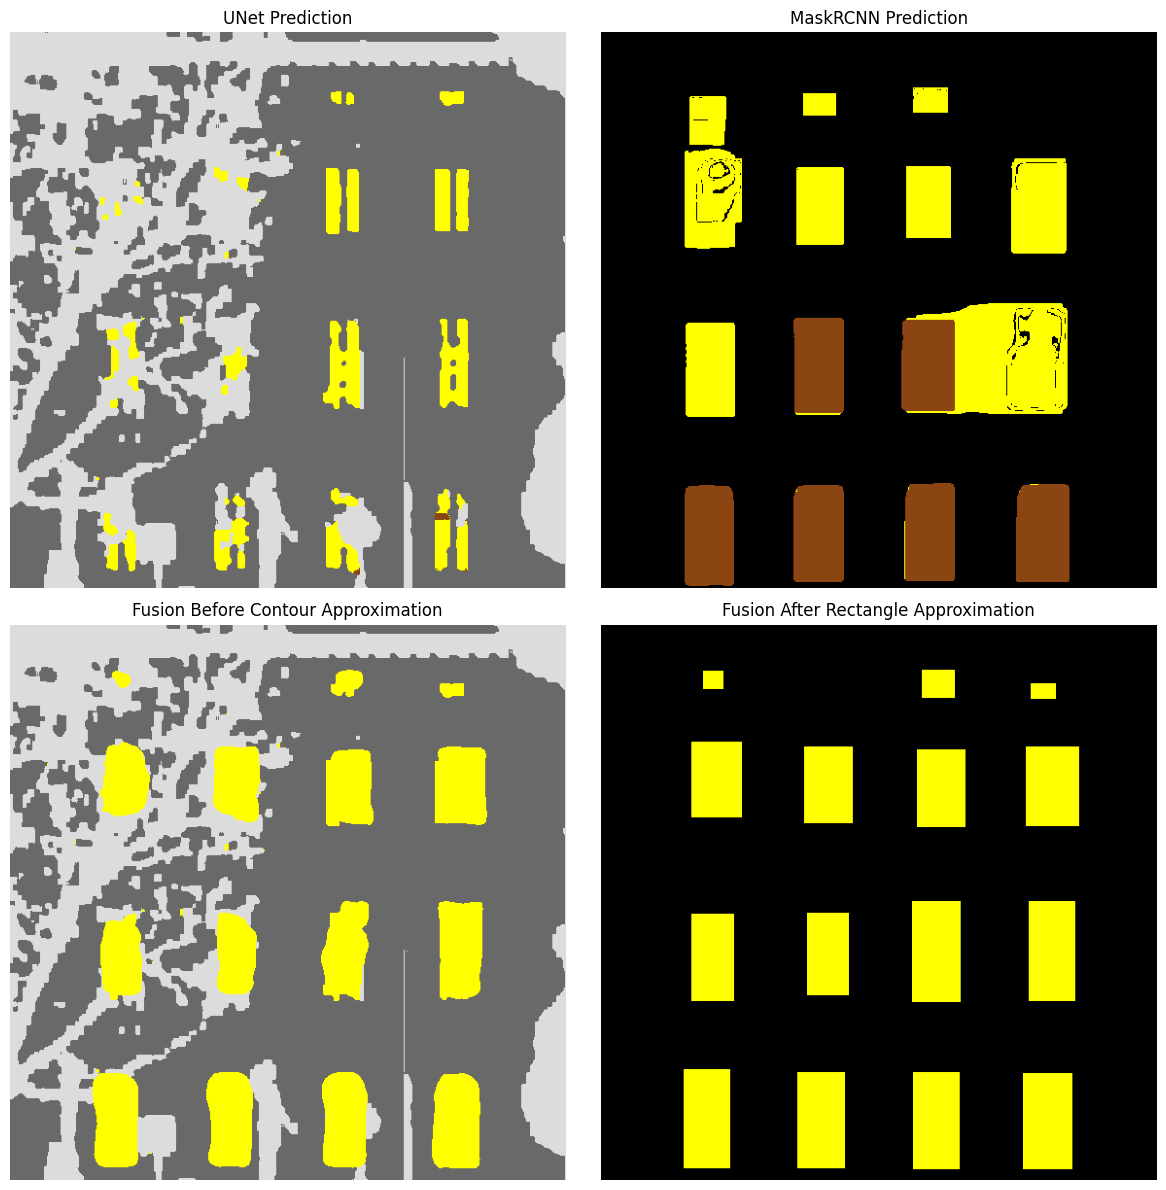

All prediction masks have been saved to: /content/drive/MyDrive/Colab Notebooks/Scan2LOD_DATA/Outputs/prediction_masks


In [134]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Create a folder for prediction masks
prediction_masks_dir = os.path.join(OUTPUT_DIR, 'prediction_masks')
os.makedirs(prediction_masks_dir, exist_ok=True)

# 1. Save UNet prediction
# The UNet prediction is available from unet_results['predictions']
unet_pred = unet_results['predictions']

# Convert UNet prediction to colored image
class_colors = {
    0: [105, 105, 105],  # Facade - Gray
    1: [255, 255, 0],    # Window - Yellow
    2: [139, 69, 19],    # Door - Brown
    3: [220, 220, 220]   # Unknown - Light Gray
}
unet_pred_colored = np.zeros((unet_pred.shape[0], unet_pred.shape[1], 3), dtype=np.uint8)
for class_idx, color in class_colors.items():
    unet_pred_colored[unet_pred == class_idx] = color

cv2.imwrite(os.path.join(prediction_masks_dir, '01_unet_prediction.png'), cv2.cvtColor(unet_pred_colored, cv2.COLOR_RGB2BGR))

# 2. Save MaskRCNN predictions (windows and doors combined)
# Create a combined MaskRCNN visualization
maskrcnn_combined = np.zeros((572, 572, 3), dtype=np.uint8)
#m2f_combined = np.zeros((572, 572, 3), dtype=np.uint8)

# Convert MaskRCNN outputs to binary masks and color them
windows_mask = (final_mask_windows.mul(255).byte().cpu().numpy() / 255) > 0.1
doors_mask = (final_mask_doors.mul(255).byte().cpu().numpy() / 255) > 0.1


#m2f_windows_mask =  mask2former_prediction[:,:,2];  # From Mask2Former
#m2f_door_mask = np.zeros((572,572));


maskrcnn_combined[windows_mask] = [255, 255, 0]  # Yellow for windows
maskrcnn_combined[doors_mask] = [139, 69, 19]    # Brown for doors

#m2f_combined[m2f_windows_mask] = [255, 255, 0]  # Yellow for windows
#m2f_combined[m2f_door_mask] = [139, 69, 19]    # Brown for doors

cv2.imwrite(os.path.join(prediction_masks_dir, '02_maskrcnn_prediction.png'), cv2.cvtColor(maskrcnn_combined, cv2.COLOR_RGB2BGR))
#cv2.imwrite(os.path.join(prediction_masks_dir, '02_m2f_prediction.png'), cv2.cvtColor(mask2former_prediction[:,:,2], cv2.COLOR_RGB2BGR))

# 3. Save fusion prediction before approximating contours
# This is final_pred before contour processing
fusion_pred_before = np.argmax(combined_probs, axis=0)
fusion_pred_before_colored = np.zeros((fusion_pred_before.shape[0], fusion_pred_before.shape[1], 3), dtype=np.uint8)
for class_idx, color in class_colors.items():
    fusion_pred_before_colored[fusion_pred_before == class_idx] = color

cv2.imwrite(os.path.join(prediction_masks_dir, '03_fusion_prediction_before_contours.png'), cv2.cvtColor(fusion_pred_before_colored, cv2.COLOR_RGB2BGR))

# 4. Save fusion prediction after approximation with rectangles
# This is generated in process_facade_openings function
# We need to visualize the contours that are actually being used for the GML

# Create an image showing the approximated rectangles
approx_contours_img = np.zeros((final_pred.shape[0], final_pred.shape[1], 3), dtype=np.uint8)

# Extract contours as done in process_facade_openings
window_mask = (final_pred == 1).astype(np.uint8) * 255
door_mask = (final_pred == 2).astype(np.uint8) * 255

window_contours, _ = cv2.findContours(window_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
door_contours, _ = cv2.findContours(door_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on area (as in the original code)
min_area = 200
max_area = 10000

filtered_window_contours = []
for contour in window_contours:
    area = cv2.contourArea(contour)
    if min_area <= area <= max_area:
        filtered_window_contours.append(contour)

filtered_door_contours = []
for contour in door_contours:
    area = cv2.contourArea(contour)
    if min_area <= area <= max_area:
        filtered_door_contours.append(contour)

# Draw rectangles for each contour
for contour in filtered_window_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(approx_contours_img, (x, y), (x + w, y + h), (255, 255, 0), -1)  # Yellow for windows

for contour in filtered_door_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(approx_contours_img, (x, y), (x + w, y + h), (139, 69, 19), -1)  # Brown for doors

cv2.imwrite(os.path.join(prediction_masks_dir, '04_fusion_prediction_after_rectangles.png'), cv2.cvtColor(approx_contours_img, cv2.COLOR_RGB2BGR))

# Create a comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(unet_pred_colored)
axes[0, 0].set_title('UNet Prediction')
axes[0, 0].axis('off')

axes[0, 1].imshow(maskrcnn_combined)
axes[0, 1].set_title('MaskRCNN Prediction')
axes[0, 1].axis('off')

axes[1, 0].imshow(fusion_pred_before_colored)
axes[1, 0].set_title('Fusion Before Contour Approximation')
axes[1, 0].axis('off')

axes[1, 1].imshow(approx_contours_img)
axes[1, 1].set_title('Fusion After Rectangle Approximation')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(prediction_masks_dir, 'all_predictions_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"All prediction masks have been saved to: {prediction_masks_dir}")